In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [29]:
# Read file
data = pd.read_csv("./consumption_temp.csv")
# Convert datatypes
data["time"] = pd.to_datetime(data["time"])
data["consumption"] = pd.to_numeric(data["consumption"])
data["temperature"] = pd.to_numeric(data["temperature"])
data_cities = {location: data[data["location"] == location] for location in data["location"].unique()}
print(data.columns)


Index(['time', 'location', 'consumption', 'temperature'], dtype='object')


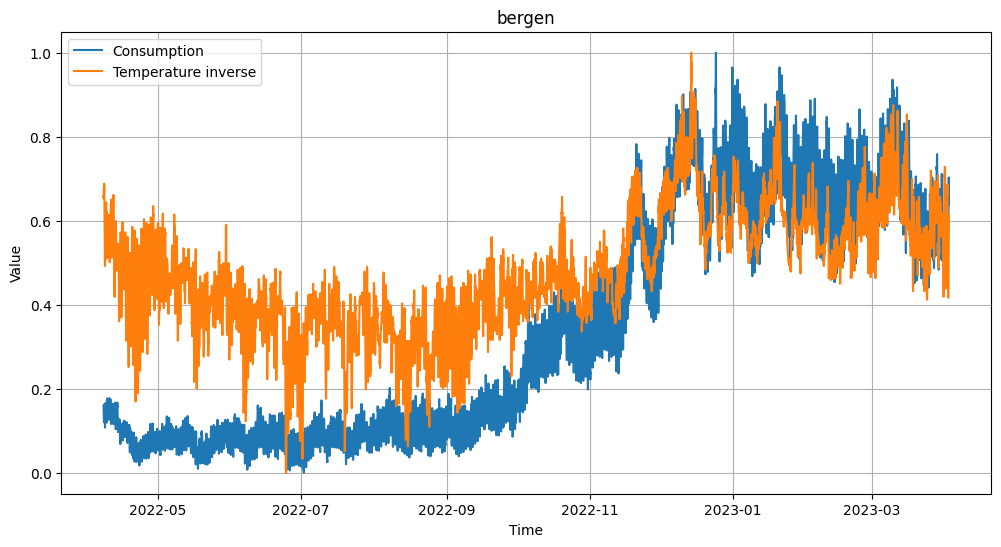

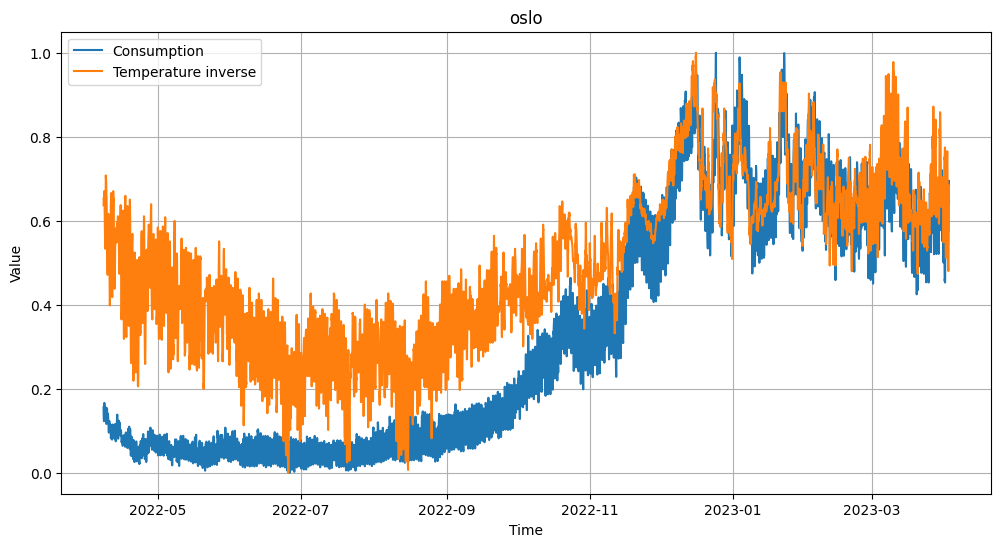

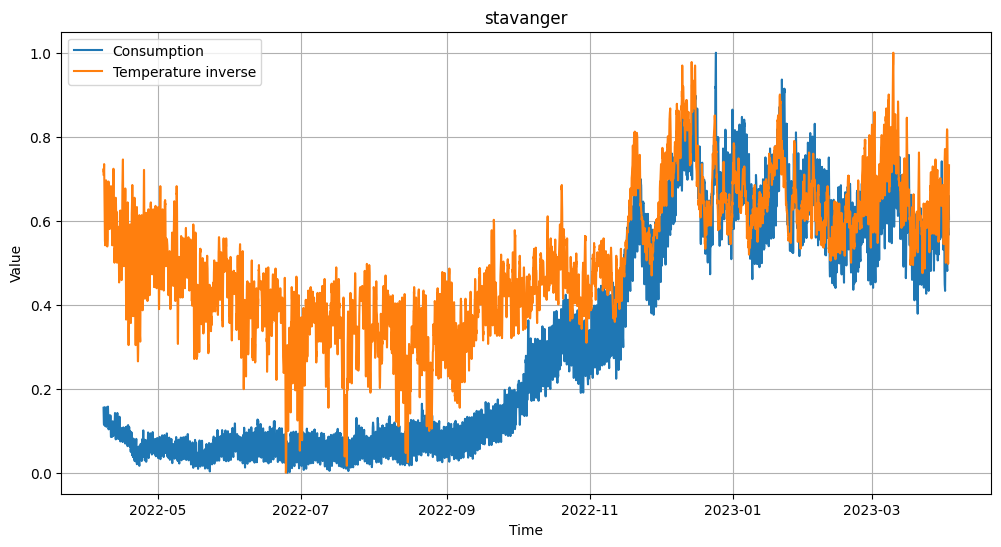

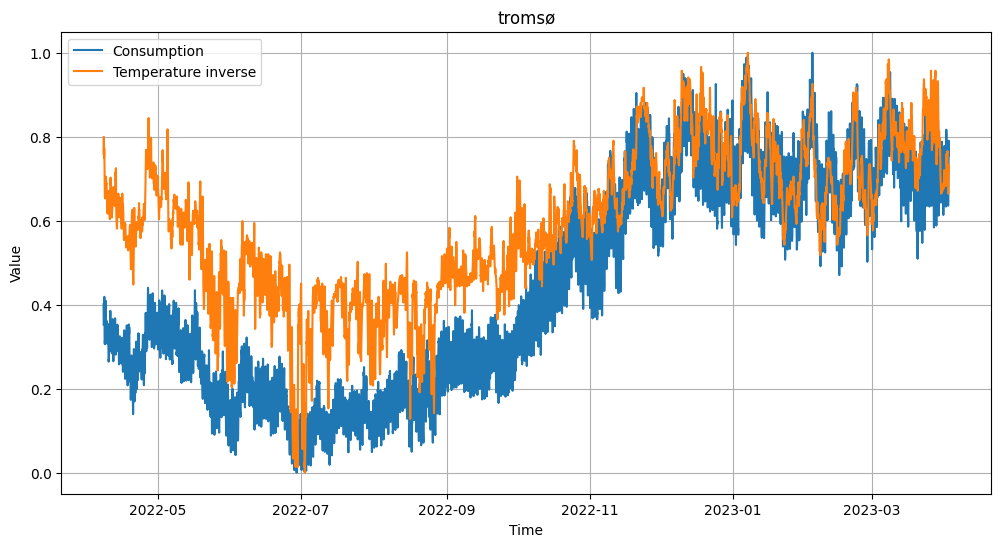

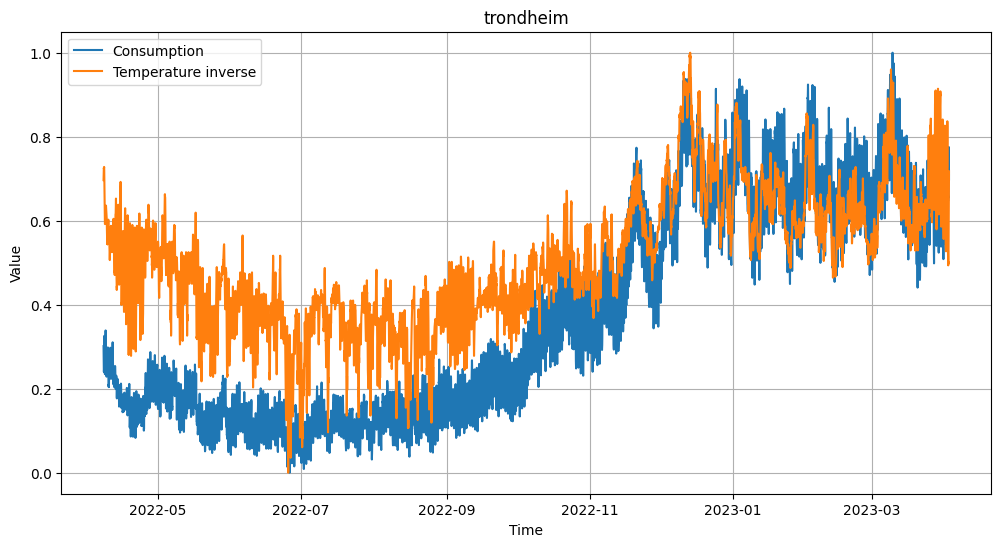

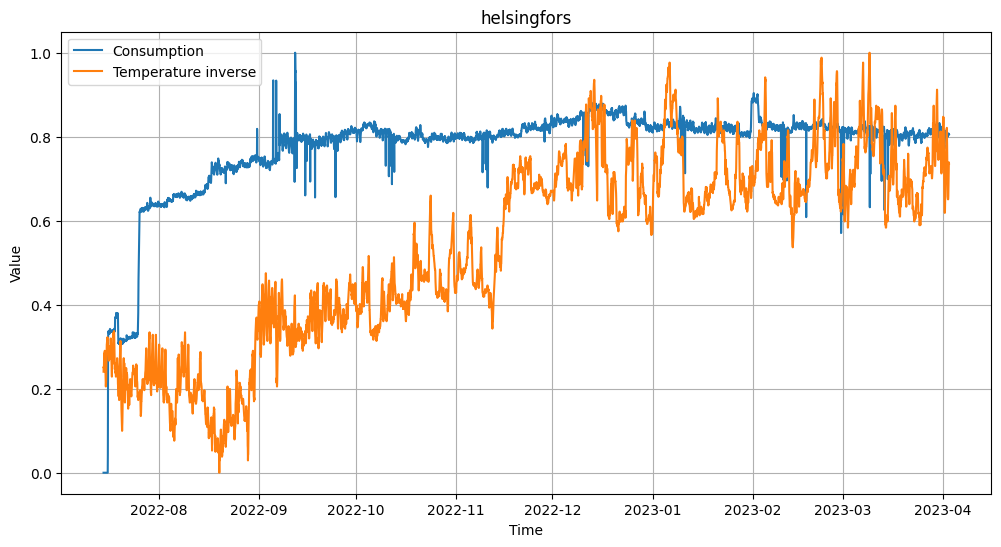

In [30]:
normalize_features = True

# Plot
for city, city_data in data_cities.items():

    # Normalize the "consumption" and "temperature" columns using Min-Max scaling
    min_consumption = city_data['consumption'].min()
    max_consumption = city_data['consumption'].max()
    min_temperature = city_data['temperature'].min()
    max_temperature = city_data['temperature'].max()

    normalized_city_data = city_data.copy()
    if normalize_features:
        normalized_city_data['consumption'] = (city_data['consumption'] - min_consumption) / (max_consumption - min_consumption)
        normalized_city_data['temperature'] = 1 - ((city_data['temperature'] - min_temperature) / (max_temperature - min_temperature))


    # Plot
    plt.figure(figsize=(12, 6))  # Set the figure size (adjust as needed)

    plt.plot(normalized_city_data['time'], normalized_city_data['consumption'], label='Consumption', linestyle='-')
    plt.plot(normalized_city_data['time'], normalized_city_data['temperature'], label='Temperature inverse', linestyle='-')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(city)
    plt.legend()
    plt.grid(True)

    plt.show()

In [31]:
# Try calculating correlation for our different features

In [32]:
data[data.location == "oslo"]

,time,location,consumption,temperature
1,2022-04-07 21:00:00,oslo,4.092830,1.0
6,2022-04-07 22:00:00,oslo,3.818095,0.4
11,2022-04-07 23:00:00,oslo,3.660981,0.3
16,2022-04-08 00:00:00,oslo,3.584066,0.2
21,2022-04-08 01:00:00,oslo,3.549536,0.4
...,...,...,...,...
49466,2023-04-02 17:00:00,oslo,12.410225,5.5
49472,2023-04-02 18:00:00,oslo,12.856381,4.8
49478,2023-04-02 19:00:00,oslo,13.010338,0.6
49484,2023-04-02 20:00:00,oslo,12.738356,-0.3


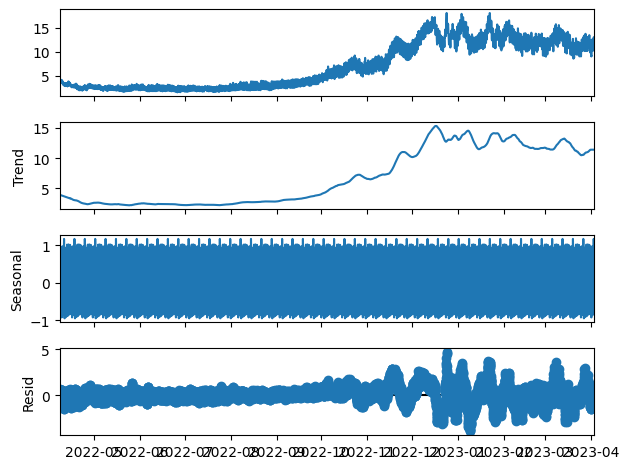

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = data[data.location == "oslo"].set_index('time')[['consumption']]
result = seasonal_decompose(series, period=7*24, model='additive', extrapolate_trend='freq', two_sided=False)
result.plot()
pyplot.show()

In [34]:
df = pd.DataFrame(result.trend + result.resid).reset_index().rename(columns={0: "y"})

In [35]:
df.merge(data[data.location == "oslo"], left_on="time", right_on="time").corr()

/var/folders/rn/zrxftcb56xg254wsfbhrtbt80000gn/T/ipykernel_15947/2615261942.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.merge(data[data.location == "oslo"], left_on="time", right_on="time").corr()


,y,consumption,temperature
y,1.000000,0.990998,-0.883241
consumption,0.990998,1.000000,-0.861854
temperature,-0.883241,-0.861854,1.000000


In [36]:
df = data[data.location == "oslo"].reset_index()
model = LinearRegression()

# Fit the model to the training data
model.fit(df.temperature.values.reshape(-1, 1), df.consumption.values.reshape(-1, 1))

# Make predictions on the test data
y_pred = model.predict(df.temperature.values.reshape(-1, 1))
df['yhat'] = y_pred
df['resid'] = df.consumption - df.yhat

<Axes: xlabel='time'>

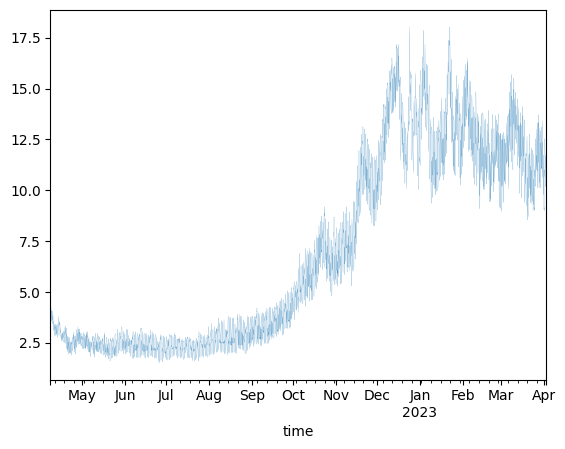

In [37]:
df.set_index("time").consumption.plot(linewidth=0.1)

<Axes: xlabel='time'>

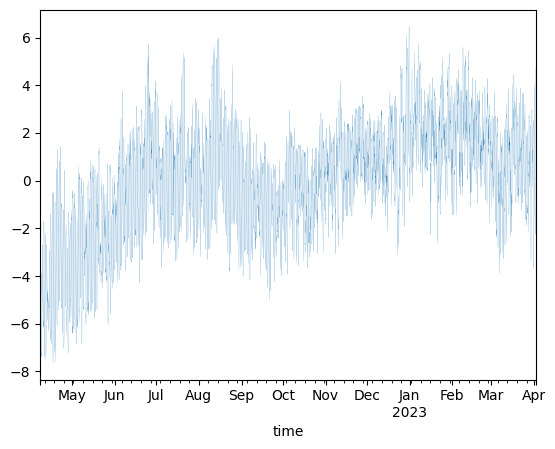

In [38]:
df.set_index("time").resid.plot(linewidth=0.1)

In [39]:
df.corr()

/var/folders/rn/zrxftcb56xg254wsfbhrtbt80000gn/T/ipykernel_15947/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,index,consumption,temperature,yhat,resid
index,1.000000,0.881536,-7.140661e-01,7.140661e-01,5.247202e-01
consumption,0.881536,1.000000,-8.618540e-01,8.618540e-01,5.071565e-01
temperature,-0.714066,-0.861854,1.000000e+00,-1.000000e+00,2.621077e-14
yhat,0.714066,0.861854,-1.000000e+00,1.000000e+00,-2.796188e-14
resid,0.524720,0.507156,2.621077e-14,-2.796188e-14,1.000000e+00


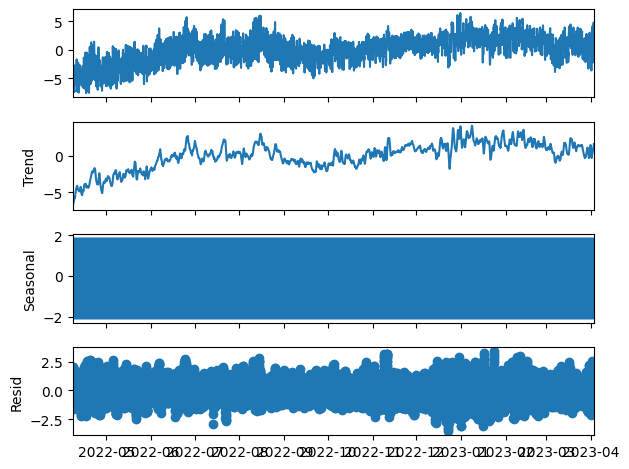

In [40]:
series = df.set_index('time')[['resid']]
result = seasonal_decompose(series, period=24, model='additive', extrapolate_trend='freq', two_sided=False)
result.plot()
pyplot.show()

<Axes: xlabel='time'>

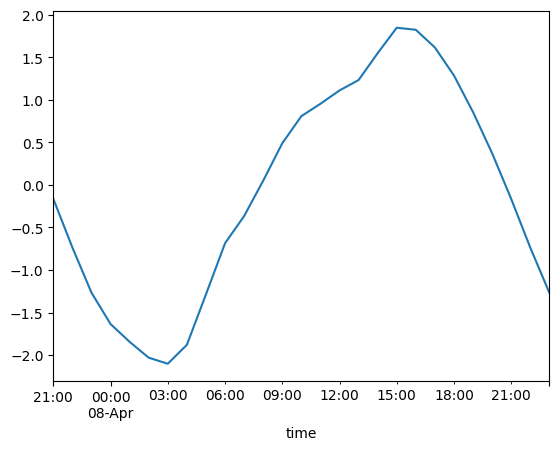

In [41]:
result.seasonal[result.seasonal.index < "2022-04-09"].plot()

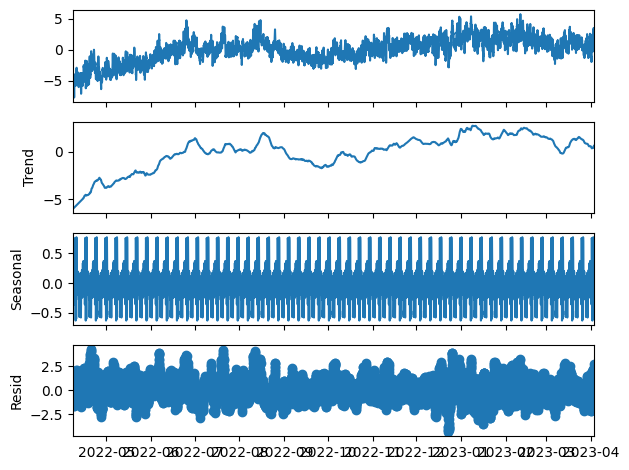

In [42]:
result2 = seasonal_decompose(result.trend + result.resid, period=7*24, model='additive', extrapolate_trend='freq', two_sided=False)
result2.plot()
pyplot.show()

<Axes: xlabel='time'>

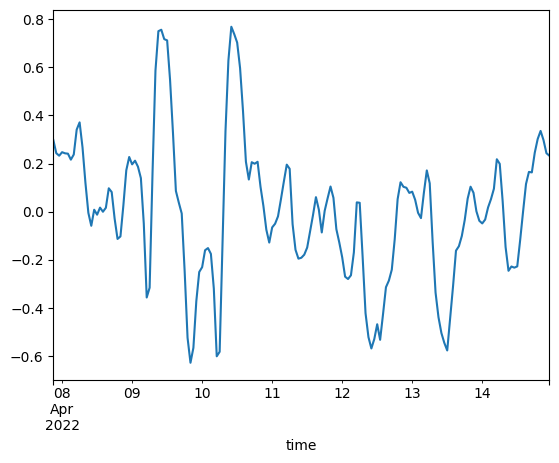

In [43]:
result2.seasonal[result2.seasonal.index < "2022-04-15"].plot()

In [44]:
df['daily_seasonal'] = pd.DataFrame(result.seasonal).reset_index().seasonal
df['weekly_seasonal'] = pd.DataFrame(result2.seasonal).reset_index().seasonal

In [45]:
df

,index,time,location,consumption,temperature,yhat,resid,daily_seasonal,weekly_seasonal
0,1,2022-04-07 21:00:00,oslo,4.092830,1.0,9.811698,-5.718868,-0.164046,0.297641
1,6,2022-04-07 22:00:00,oslo,3.818095,0.4,10.087186,-6.269091,-0.736876,0.243227
2,11,2022-04-07 23:00:00,oslo,3.660981,0.3,10.133101,-6.472120,-1.266874,0.232783
3,16,2022-04-08 00:00:00,oslo,3.584066,0.2,10.179015,-6.594949,-1.635479,0.247328
4,21,2022-04-08 01:00:00,oslo,3.549536,0.4,10.087186,-6.537650,-1.844674,0.242668
...,...,...,...,...,...,...,...,...,...
8636,49466,2023-04-02 17:00:00,oslo,12.410225,5.5,7.745539,4.664686,1.615833,0.205663
8637,49472,2023-04-02 18:00:00,oslo,12.856381,4.8,8.066941,4.789440,1.286642,0.199343
8638,49478,2023-04-02 19:00:00,oslo,13.010338,0.6,9.995357,3.014981,0.856355,0.207491
8639,49484,2023-04-02 20:00:00,oslo,12.738356,-0.3,10.408588,2.329768,0.372667,0.103984


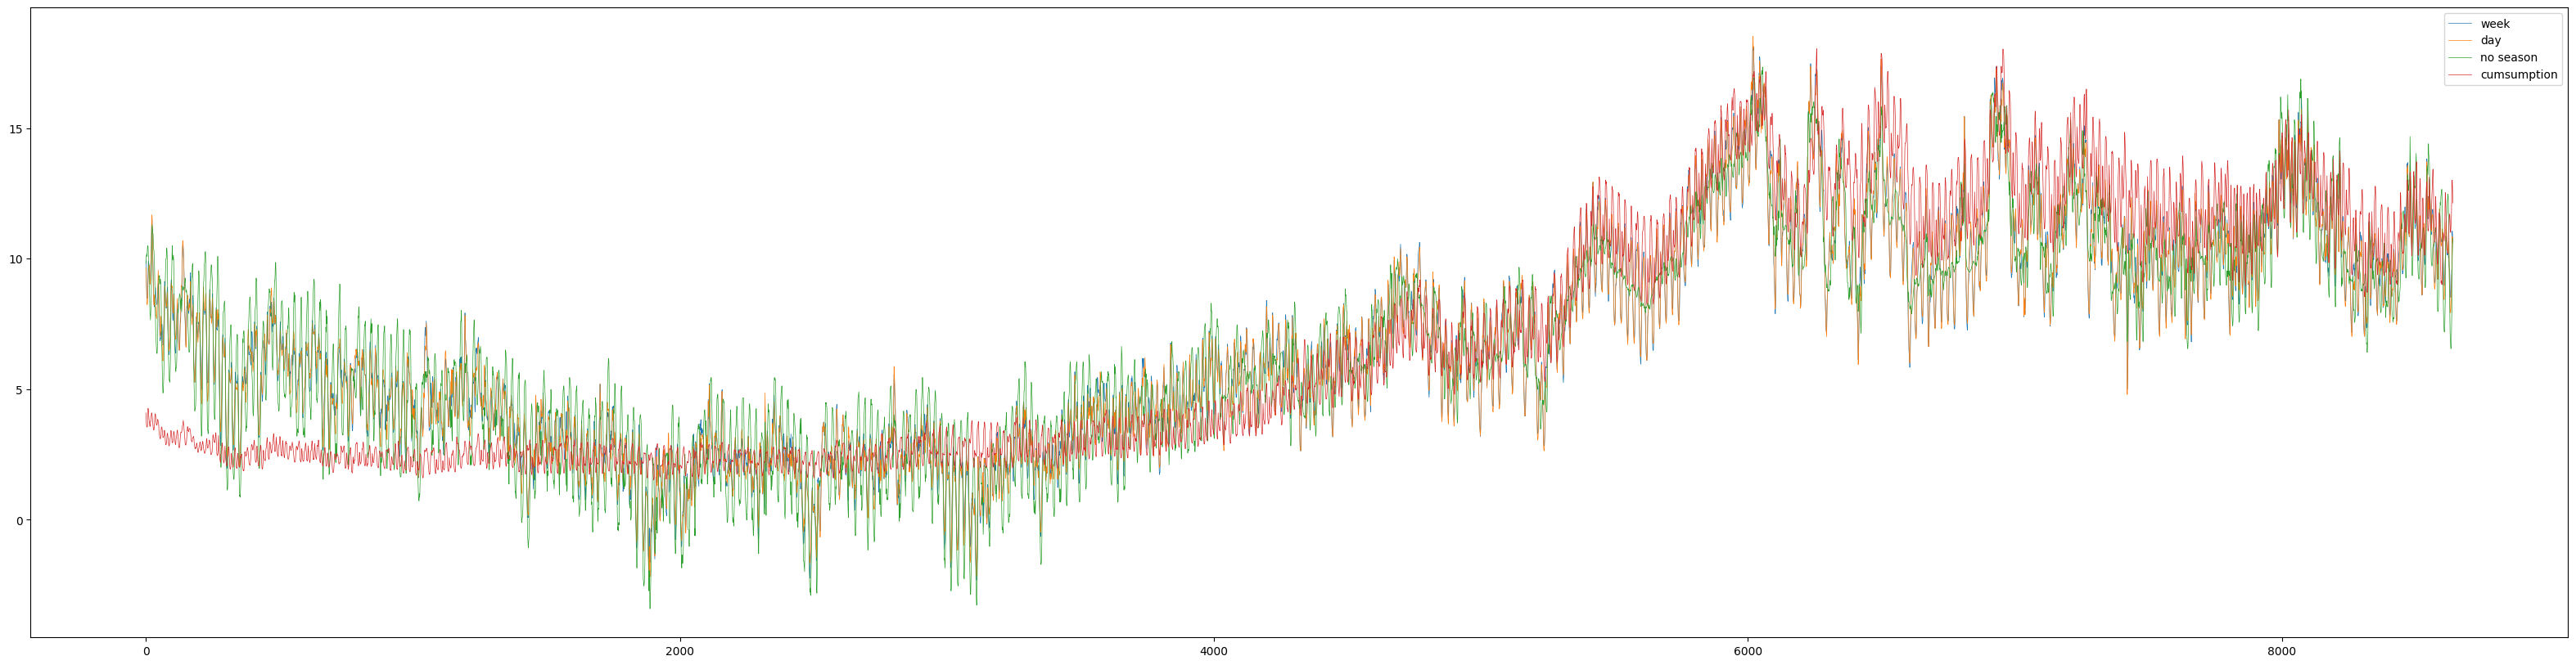

In [46]:
fig, ax = plt.subplots(figsize=(40,10))
ax.plot(df.yhat+df.weekly_seasonal+df.daily_seasonal, label="week", linewidth=0.5)
ax.plot(df.yhat+df.daily_seasonal, label="day", linewidth=0.5)
ax.plot(df.yhat, label="no season", linewidth=0.5)
ax.plot(df.consumption, label="cumsumption", linewidth=0.5)
ax.legend()
plt.show()

In [47]:
df['yhat_w_day'] = df.yhat+df.daily_seasonal

In [48]:
df['yhat_w_day_and_week'] = df.yhat+df.daily_seasonal+df.weekly_seasonal

In [49]:
df.mae()

/var/folders/rn/zrxftcb56xg254wsfbhrtbt80000gn/T/ipykernel_15947/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,index,consumption,temperature,yhat,resid,daily_seasonal,weekly_seasonal,yhat_w_day,yhat_w_day_and_week
index,1.000000,0.881536,-7.140661e-01,7.140661e-01,5.247202e-01,0.002177,0.000642,0.727702,0.726519
consumption,0.881536,1.000000,-8.618540e-01,8.618540e-01,5.071565e-01,0.095184,0.049045,0.909052,0.911139
temperature,-0.714066,-0.861854,1.000000e+00,-1.000000e+00,2.621077e-14,0.217076,0.015133,-0.945987,-0.943270
yhat,0.714066,0.861854,-1.000000e+00,1.000000e+00,-2.796188e-14,-0.217076,-0.015133,0.945987,0.943270
resid,0.524720,0.507156,2.621077e-14,-2.796188e-14,1.000000e+00,0.556576,0.122423,0.184852,0.193584
daily_seasonal,0.002177,0.095184,2.170756e-01,-2.170756e-01,5.565761e-01,1.000000,0.003922,0.111123,0.111225
weekly_seasonal,0.000642,0.049045,1.513318e-02,-1.513318e-02,1.224229e-01,0.003922,1.000000,-0.014104,0.059801
yhat_w_day,0.727702,0.909052,-9.459871e-01,9.459871e-01,1.848522e-01,0.111123,-0.014104,1.000000,0.997268
yhat_w_day_and_week,0.726519,0.911139,-9.432700e-01,9.432700e-01,1.935845e-01,0.111225,0.059801,0.997268,1.000000


In [50]:
((df.consumption - df.yhat_w_day)**2).mean()

3.875696859205856

In [51]:
from prophet import Prophet

In [52]:
df

,index,time,location,consumption,temperature,yhat,resid,daily_seasonal,weekly_seasonal,yhat_w_day,yhat_w_day_and_week
0,1,2022-04-07 21:00:00,oslo,4.092830,1.0,9.811698,-5.718868,-0.164046,0.297641,9.647652,9.945293
1,6,2022-04-07 22:00:00,oslo,3.818095,0.4,10.087186,-6.269091,-0.736876,0.243227,9.350310,9.593537
2,11,2022-04-07 23:00:00,oslo,3.660981,0.3,10.133101,-6.472120,-1.266874,0.232783,8.866226,9.099009
3,16,2022-04-08 00:00:00,oslo,3.584066,0.2,10.179015,-6.594949,-1.635479,0.247328,8.543536,8.790864
4,21,2022-04-08 01:00:00,oslo,3.549536,0.4,10.087186,-6.537650,-1.844674,0.242668,8.242511,8.485179
...,...,...,...,...,...,...,...,...,...,...,...
8636,49466,2023-04-02 17:00:00,oslo,12.410225,5.5,7.745539,4.664686,1.615833,0.205663,9.361371,9.567034
8637,49472,2023-04-02 18:00:00,oslo,12.856381,4.8,8.066941,4.789440,1.286642,0.199343,9.353583,9.552926
8638,49478,2023-04-02 19:00:00,oslo,13.010338,0.6,9.995357,3.014981,0.856355,0.207491,10.851711,11.059202
8639,49484,2023-04-02 20:00:00,oslo,12.738356,-0.3,10.408588,2.329768,0.372667,0.103984,10.781255,10.885240


In [53]:
pr_df = df[['time', 'consumption', 'temperature']].copy()

In [56]:
pr_df.rename(columns={'time':'ds', 'consumption': 'y'}, inplace=True)

In [70]:
m = Prophet()
m.add_regressor('temperature')
m.fit(pr_df)
fcst = m.predict(pr_df)

12:47:42 - cmdstanpy - INFO - Chain [1] start processing
12:47:43 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
help(m.plot)

Help on method plot in module prophet.forecaster:

plot(fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y', figsize=(10, 6), include_legend=False) method of prophet.forecaster.Prophet instance
    Plot the Prophet forecast.
    
    Parameters
    ----------
    fcst: pd.DataFrame output of self.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    include_legend: Optional boolean to add legend to the plot.
    
    Returns
    -------
    A matplotlib figure.



In [73]:
m.plot(fcst, linewidth=0.1)

TypeError: Prophet.plot() got an unexpected keyword argument 'linewidth'

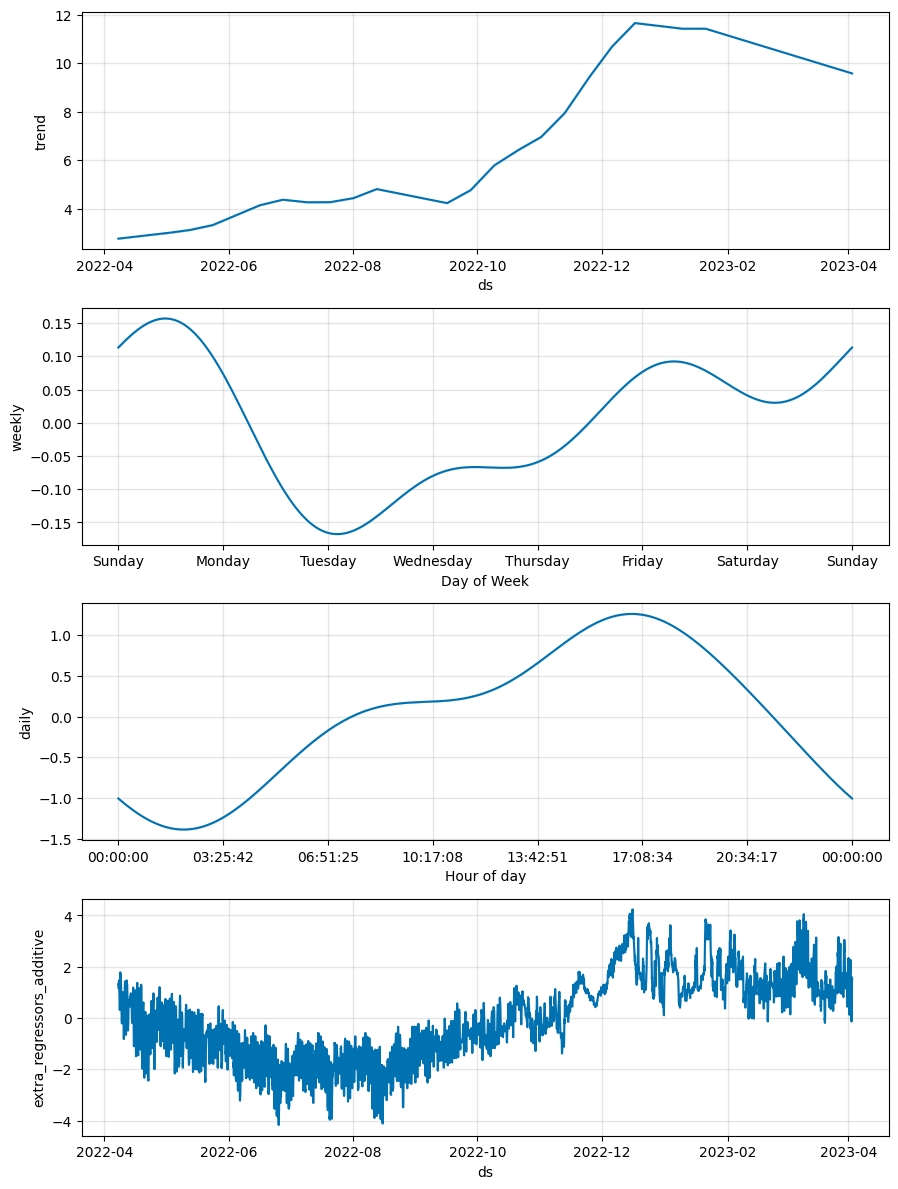

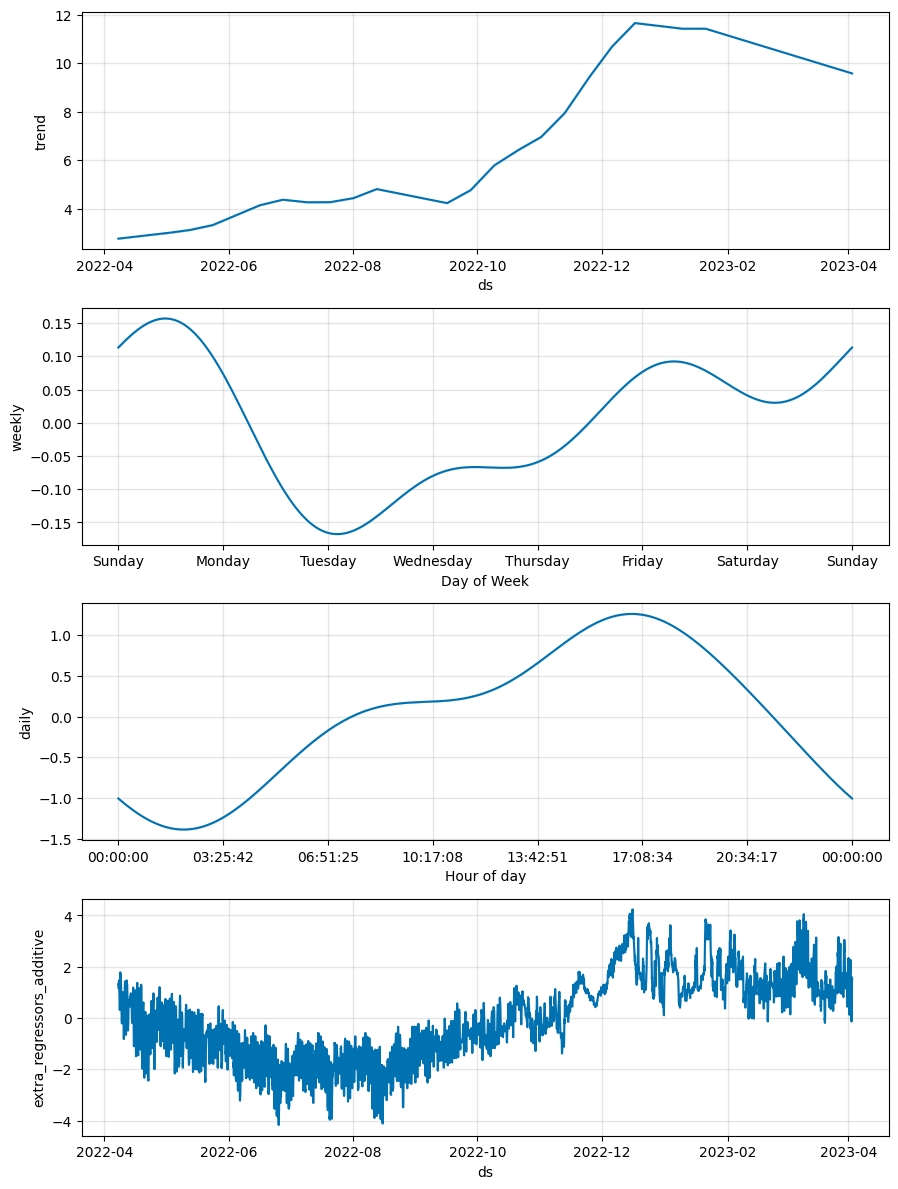

In [71]:
m.plot_components(fcst)

In [75]:
from prophet.utilities import regressor_coefficients

In [76]:
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,temperature,additive,7.392883,-0.1859,-0.1859,-0.1859


In [64]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='300 days', period='14 days', horizon = '7 days')

  0%|          | 0/4 [00:00<?, ?it/s]

11:18:31 - cmdstanpy - INFO - Chain [1] start processing
11:18:32 - cmdstanpy - INFO - Chain [1] done processing
11:18:32 - cmdstanpy - INFO - Chain [1] start processing
11:18:34 - cmdstanpy - INFO - Chain [1] done processing
11:18:34 - cmdstanpy - INFO - Chain [1] start processing
11:18:37 - cmdstanpy - INFO - Chain [1] done processing
11:18:38 - cmdstanpy - INFO - Chain [1] start processing
11:18:39 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 17:00:00,1.170198,1.081757,0.798666,0.076605,0.050114,0.072352,0.597015
1,0 days 18:00:00,1.271749,1.127718,0.845123,0.080966,0.062545,0.076325,0.567164
2,0 days 19:00:00,1.334900,1.155379,0.886887,0.084239,0.071965,0.079500,0.522388
3,0 days 20:00:00,1.389710,1.178859,0.922711,0.086769,0.076791,0.082023,0.492537
4,0 days 21:00:00,1.422226,1.192571,0.945251,0.088039,0.077653,0.083385,0.481343


In [69]:
df_p.describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,152,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,3 days 20:30:00,0.900660,0.938498,0.764803,0.069108,0.058099,0.066682,0.625638
std,1 days 20:01:21.797061997,0.266016,0.141470,0.114672,0.011361,0.011330,0.010245,0.086138
min,0 days 17:00:00,0.355224,0.596007,0.460590,0.038978,0.032793,0.038654,0.481343
25%,2 days 06:45:00,0.699918,0.836611,0.700527,0.061906,0.049767,0.060579,0.555970
50%,3 days 20:30:00,0.847502,0.920598,0.768228,0.070130,0.057960,0.067141,0.619403
75%,5 days 10:15:00,1.115046,1.055957,0.862538,0.078093,0.067036,0.074743,0.675373
max,7 days 00:00:00,1.475798,1.214824,0.968127,0.088482,0.078639,0.084090,0.858209


In [67]:
df_cv.corr()

/var/folders/rn/zrxftcb56xg254wsfbhrtbt80000gn/T/ipykernel_15947/2864518407.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_cv.corr()


,yhat,yhat_lower,yhat_upper,y
yhat,1.000000,0.999162,0.999111,0.634023
yhat_lower,0.999162,1.000000,0.998329,0.629428
yhat_upper,0.999111,0.998329,1.000000,0.638884
y,0.634023,0.629428,0.638884,1.000000


,index,time,location,consumption,temperature,yhat,resid,daily_seasonal,weekly_seasonal,yhat_w_day,yhat_w_day_and_week
0,1,2022-04-07 21:00:00,oslo,4.092830,1.0,9.811698,-5.718868,-0.164046,0.297641,9.647652,9.945293
1,6,2022-04-07 22:00:00,oslo,3.818095,0.4,10.087186,-6.269091,-0.736876,0.243227,9.350310,9.593537
2,11,2022-04-07 23:00:00,oslo,3.660981,0.3,10.133101,-6.472120,-1.266874,0.232783,8.866226,9.099009
3,16,2022-04-08 00:00:00,oslo,3.584066,0.2,10.179015,-6.594949,-1.635479,0.247328,8.543536,8.790864
4,21,2022-04-08 01:00:00,oslo,3.549536,0.4,10.087186,-6.537650,-1.844674,0.242668,8.242511,8.485179
...,...,...,...,...,...,...,...,...,...,...,...
8636,49466,2023-04-02 17:00:00,oslo,12.410225,5.5,7.745539,4.664686,1.615833,0.205663,9.361371,9.567034
8637,49472,2023-04-02 18:00:00,oslo,12.856381,4.8,8.066941,4.789440,1.286642,0.199343,9.353583,9.552926
8638,49478,2023-04-02 19:00:00,oslo,13.010338,0.6,9.995357,3.014981,0.856355,0.207491,10.851711,11.059202
8639,49484,2023-04-02 20:00:00,oslo,12.738356,-0.3,10.408588,2.329768,0.372667,0.103984,10.781255,10.885240
